In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-1d-test.parquet")
df["total_params1"] = df["shape1[0]"]# * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"]# * df["shape2[1]"]
print(len(df))
df.tail()

60000


,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2
59995,45,949,full,19998,0.000166,0.000067,45,949
59996,45,949,same,19998,0.000179,0.000518,45,949
59997,23489,45440,valid,19999,0.003046,0.099871,23489,45440
59998,23489,45440,full,19999,0.002872,0.213914,23489,45440
59999,23489,45440,same,19999,0.002797,13.728895,23489,45440


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")
from common import _fftconv_faster_test as _fftconv_faster

In [4]:

def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], )
    h_shape = (row["shape2[0]"], )
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode, test=False)

In [5]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

df["correct"] = (df.faster == df.faster_est)
acc = df["correct"].sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 89.40% of the time


**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [6]:
idx = (df["mode"] == "same") & (df["shape1[0]"] < df["shape2[0]"])
df["cond"] = "a"
df.loc[idx, "cond"] = "sp_conv"
idx = (df["mode"] == "same") & (df["shape1[0]"] >= df["shape2[0]"])
df.loc[idx, "cond"] = "np_conv"

In [7]:
df.groupby(["mode", "cond"])["correct"].count()

mode   cond   
full   a          20000
same   np_conv    10058
       sp_conv     9942
valid  a          20000
Name: correct, dtype: int64

In [66]:
t = show = df.pivot_table(
    columns="cond",
    index="mode",
    values="correct",
    aggfunc=np.mean,
).reset_index()
t = t.melt(id_vars=["mode"]).dropna()
print(t)
# t[t.cond != "a"]

    mode     cond     value
0   full        a  0.919950
2  valid        a  0.922150
4   same  np_conv  0.914993
7   same  sp_conv  0.763730


In [9]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong.copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond,ratio
46379,7,89548,same,15459,0.003016,0.006837,7,89548,fft,direct,False,sp_conv,2.266798
42335,8,87408,same,14111,0.003491,0.006859,8,87408,fft,direct,False,sp_conv,1.964961
38426,8,68898,same,12808,0.002672,0.006923,8,68898,fft,direct,False,sp_conv,2.590970
20807,7,89839,same,6935,0.004617,0.007004,7,89839,fft,direct,False,sp_conv,1.516807
7034,8,83552,same,2344,0.003339,0.007065,8,83552,fft,direct,False,sp_conv,2.116038
59186,8,91461,same,19728,0.003835,0.007266,8,91461,fft,direct,False,sp_conv,1.894560
18788,7,99658,same,6262,0.003454,0.007277,7,99658,fft,direct,False,sp_conv,2.107000
1637,7,99945,same,545,0.003983,0.007282,7,99945,fft,direct,False,sp_conv,1.828435
13367,8,94117,same,4455,0.003378,0.007508,8,94117,fft,direct,False,sp_conv,2.222756
41366,8,95034,same,13788,0.003869,0.008095,8,95034,fft,direct,False,sp_conv,2.092186


In [10]:
vals["correct"] = (vals["faster"] == vals["faster_est"])#.astype(float)
print(vals["faster"].unique())
print(vals["faster_est"].unique())
print(vals.correct.unique())

vals.pivot_table(
    index="mode",
    values="correct",
    aggfunc=np.mean,
)

['direct' 'fft']
['fft' 'direct']
[False]


,correct
mode,
full,False
same,False
valid,False


In [11]:
vals.ratio.max()

18.698507462686567

In [12]:
vals.direct_time.min()

-0.032315969467163086

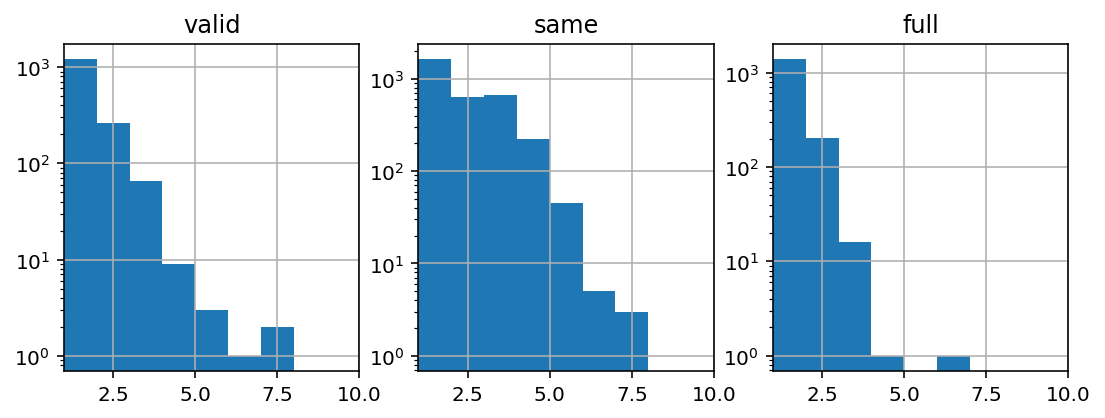

In [13]:
lims = range(int(wrong.ratio.max() + 1))

import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(ncols=3, figsize=(3*w, w))
for mode, ax in zip(["valid", "same", "full"], axs):
    show = wrong[wrong["mode"] == mode]
    ax = show.ratio.hist(bins=lims, ax=ax)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_title(mode)
    _ = ax.set_xlim(1, 10)
    _ = ax.set_yscale("log")

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [23]:
i = (df["mode"] == "valid") & (df.faster_est == "direct")
df[i]

,shape1[0],shape2[0],mode,seed,fft_time,direct_time,total_params1,total_params2,faster,faster_est,correct,cond
3,230,5433,valid,1,0.000448,0.000371,230,5433,direct,direct,True,a
6,281,3,valid,2,0.000236,0.000032,281,3,direct,direct,True,a
15,30,26021,valid,5,0.001302,0.000763,30,26021,direct,direct,True,a
18,32765,95,valid,6,0.001672,0.001298,32765,95,direct,direct,True,a
21,6,10106,valid,7,0.000515,0.000045,6,10106,direct,direct,True,a
...,...,...,...,...,...,...,...,...,...,...,...,...
59982,8688,3,valid,19994,0.000996,0.000038,8688,3,direct,direct,True,a
59985,14,266,valid,19995,0.000170,0.000032,14,266,direct,direct,True,a
59988,162,5,valid,19996,0.000161,0.000026,162,5,direct,direct,True,a
59991,6,3,valid,19997,0.000146,0.000024,6,3,direct,direct,True,a


In [29]:
for mode in ["full", "valid", "same"]:
    print(mode)
    for i in np.linspace(1, 12 + 1):
        idx = wrong["mode"] == mode
        prob = (wrong[idx].ratio <= i).sum() / idx.sum()
        msg = f"P(ratio <= {i:0.2f}) = {100 * prob:0.1f}%"
        if 0.9 <= prob <= 0.99:
            print(msg)

full
P(ratio <= 2.22) = 92.1%
P(ratio <= 2.47) = 95.5%
P(ratio <= 2.71) = 97.9%
P(ratio <= 2.96) = 98.9%
valid
P(ratio <= 2.71) = 91.5%
P(ratio <= 2.96) = 94.2%
P(ratio <= 3.20) = 96.3%
P(ratio <= 3.45) = 97.3%
P(ratio <= 3.69) = 98.1%
P(ratio <= 3.94) = 98.7%
P(ratio <= 4.18) = 98.8%
same
P(ratio <= 3.94) = 90.1%
P(ratio <= 4.18) = 94.1%
P(ratio <= 4.43) = 95.9%
P(ratio <= 4.67) = 96.9%
P(ratio <= 4.92) = 98.1%


valid a 1557
same np_conv 855
same sp_conv 2349
full a 1601


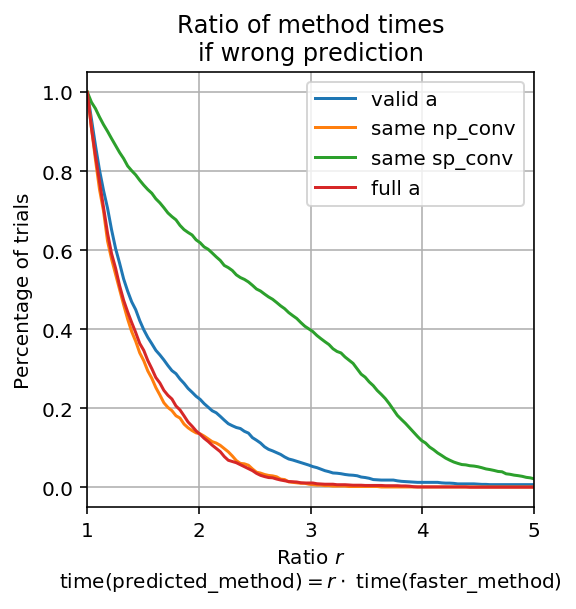

In [65]:
lims = np.linspace(1, int(wrong.ratio.max() + 1), num=500)

import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["valid", "same", "full"]:
    conds = "a" if mode != "same" else ["np_conv", "sp_conv"]
    for cond in conds:
        idx = (wrong["mode"] == mode) & (wrong["cond"] == cond)
        print(mode, cond, idx.sum())
        show = wrong[(wrong["mode"] == mode) & (wrong["cond"] == cond)]
        cdf = {i: (show.ratio <= i).sum() / len(show) for i in lims}
        ax = (1 - pd.Series(cdf)).plot(ax=ax, label=mode + " " + cond)
ax.grid()
ax.legend(loc="best")
# ax.set_yscale("log")
# _ = ax.set_ylim(0.5, 1)
_ = ax.set_title("Ratio of method times\nif wrong prediction")
_ = ax.set_ylabel("Percentage of trials")
_ = ax.set_xlabel("Ratio $r$\n" + r"time(predicted_method)$= r \cdot$ time(faster_method)")
_ = ax.set_xlim(1, 5)
DIR = "/Users/scott/Desktop/"
plt.savefig(DIR + "1d-wrong-factor.png", bbox_inches="tight")

In [52]:
df.columns

Index(['shape1[0]', 'shape2[0]', 'mode', 'seed', 'fft_time', 'direct_time',
       'total_params1', 'total_params2', 'faster', 'faster_est', 'correct',
       'cond'],
      dtype='object')

FFT >2x faster for 23.60% of tests in mode=full and cond=np_conv
full


FFT >2x faster for 23.60% of tests in mode=full and cond=sp_conv
full


FFT >2x faster for 20.32% of tests in mode=valid and cond=np_conv
valid


FFT >2x faster for 20.32% of tests in mode=valid and cond=sp_conv
valid


FFT >2x faster for 22.57% of tests in mode=same and cond=np_conv
np_conv


FFT >2x faster for 64.31% of tests in mode=same and cond=sp_conv
sp_conv


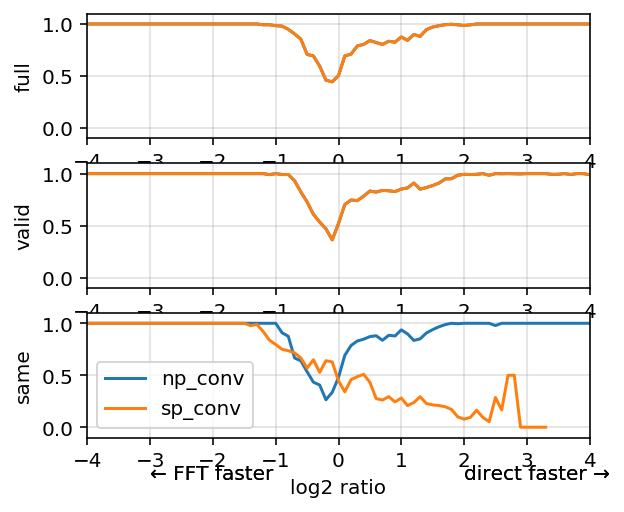

In [53]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode", "cond", "direct_time"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)
show["direct_time_binned"] = np.round(show.direct_time, decimals=1)

w = 3
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.3 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    for cond in ["np_conv", "sp_conv"]:
        if mode != "same":
            s = show[show["mode"] == mode]
        else:
            idx = (show["mode"] == mode) & (show["cond"] == cond)
            s = show[idx]
        frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
        print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode} and cond={cond}")
        correct_predictions = s.pivot_table(
            index="log_ratio_binned",
            values="correct",
            aggfunc=np.mean
        )
        label = mode if mode != "same" else cond
        print(label)
        ax.plot(correct_predictions, label=label)
        _ = ax.set_xlim(-4, 4)
        _ = ax.set_ylim(-0.1, 1.1)
#         _ = ax.plot([0, 0], ax.get_ylim())
        _ = ax.set_ylabel(mode)
        _ = ax.grid(alpha=0.4)
#         ax.legend_.remove()
        if i == 2:
            _ = ax.set_xlabel("log2 ratio")
            _ = ax.text(-3, -0.5, "← FFT faster")
            _ = ax.text(2, -0.5, "direct faster →")
            _ = ax.legend(loc="best")

FFT >2x faster for 23.60% of tests in mode=full and cond=np_conv
full
FFT >2x faster for 20.32% of tests in mode=valid and cond=np_conv
valid
FFT >2x faster for 22.57% of tests in mode=same and cond=np_conv
np_conv
FFT >2x faster for 64.31% of tests in mode=same and cond=sp_conv
sp_conv


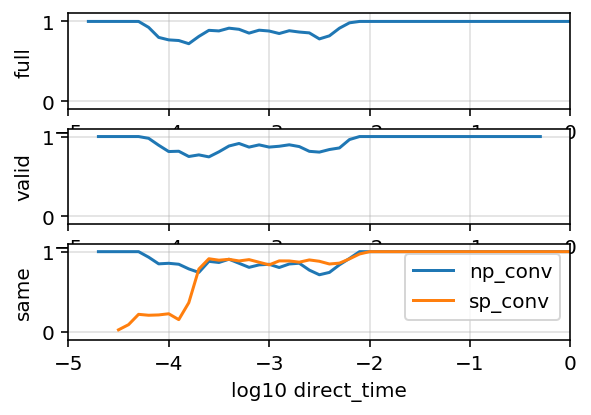

In [55]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode", "cond", "direct_time"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)
show["log10(direct_time_binned)"] = np.round(np.log10(show.direct_time), decimals=1)

w = 3
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    for cond in ["np_conv", "sp_conv"]:
        if mode != "same":
            s = show[show["mode"] == mode]
        else:
            idx = (show["mode"] == mode) & (show["cond"] == cond)
            s = show[idx]
        if "sp" in cond and mode != "same":
            continue
        frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
        print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode} and cond={cond}")
        correct_predictions = s.pivot_table(
            #index="log_ratio_binned",
            index="log10(direct_time_binned)",
            values="correct",
            aggfunc=np.mean
        )
        label = mode if mode != "same" else cond
        print(label)
        ax.plot(correct_predictions, label=label)
#         _ = ax.set_xlim(-4, 4)
        _ = ax.set_ylim(-0.1, 1.1)
        _ = ax.legend(loc="best")
#         _ = ax.plot([0, 0], ax.get_ylim())
        _ = ax.set_ylabel(mode)
        _ = ax.grid(which="both", alpha=0.4)
        _ = ax.set_xlim(-5, 0)
        ax.legend_.remove()
        if i == 2:
            _ = ax.set_xlabel("log10 direct_time")
            ax.legend(loc="best")
#             ax.set_xlim(-4, -3)
plt.savefig(DIR + "1d-direct-time-correct.png", bbox_inches="tight")

In [19]:
df.columns

Index(['shape1[0]', 'shape2[0]', 'mode', 'seed', 'fft_time', 'direct_time',
       'total_params1', 'total_params2', 'faster', 'faster_est', 'correct',
       'cond'],
      dtype='object')

In [20]:
idx = (df["mode"] == "same") & (df.cond == "np_conv")
print(df.loc[idx, "faster_est"].value_counts())
print(df.loc[idx, "faster"].value_counts())

idx = (df["mode"] == "same") & (df.cond == "sp_conv")
print(df.loc[idx, "faster_est"].value_counts())
print(df.loc[idx, "faster"].value_counts())

direct    6908
fft       3150
Name: faster_est, dtype: int64
direct    6827
fft       3231
Name: faster, dtype: int64
fft       8950
direct     992
Name: faster_est, dtype: int64
fft       7283
direct    2659
Name: faster, dtype: int64


FFT >2x faster for 23.60% of tests in mode=full
FFT >2x faster for 20.32% of tests in mode=valid
FFT >2x faster for 43.32% of tests in mode=same


Text(0.5, 0, 'number')

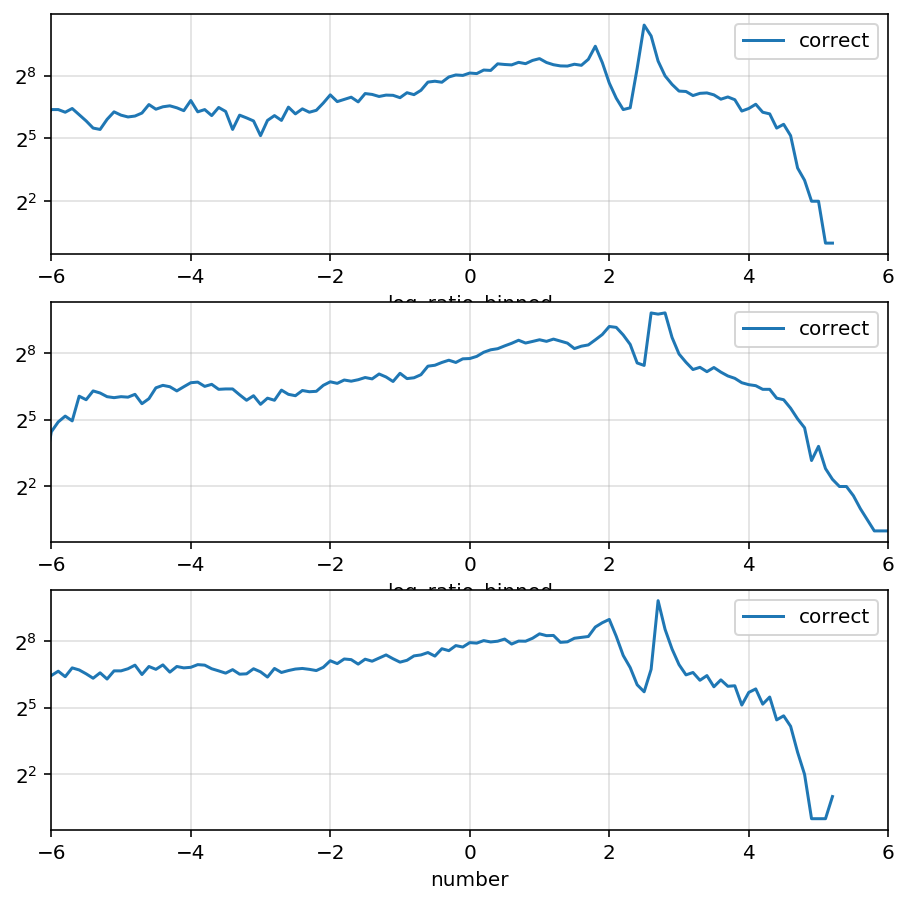

In [21]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

w = 5
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.5 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    s = show[show["mode"] == mode]
    frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
    print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode}")
    num = s.pivot_table(
        index="log_ratio_binned",
        values="correct",
        aggfunc=len,
    )
    _ = ax = num.plot(ax=ax)
    ax.set_yscale("log", basey=2)
    _ = ax.set_xlim(-6, 6)
#     _ = ax.set_ylim(-0.1, 1.1)
#     _ = ax.plot([0, 0], ax.get_ylim())
#     _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("number")
#         ax.text(-3, -0.5, "← FFT faster")
#         ax.text(2, -0.5, "direct faster →")
#     else:
#         ax.legend_.remove()